## Lab1 : back-propagation

In [697]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=6) 

In [698]:
def generate_linear(n=100):
    import numpy as np
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

In [699]:
def generate_XOR_easy():
    import numpy as np
    inputs = []
    labels = []
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        if 0.1*i == 0.5:
            continue
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
    return np.array(inputs), np.array(labels).reshape(21, 1)

### NeuralNetwork

In [ ]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, optimizer="sgd", activation="sigmoid", lr=0.01, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.output_dim = output_dim
        self.lr = lr
        self.optimizer = optimizer

        self.W1 = np.random.randn(input_dim, hidden_dim1) 
        self.b1 = np.zeros((1, hidden_dim1))

        self.W2 = np.random.randn(hidden_dim1, hidden_dim2) 
        self.b2 = np.zeros((1, hidden_dim2))

        self.W3 = np.random.randn(hidden_dim2, output_dim) 
        self.b3 = np.zeros((1, output_dim))

        if activation == "sigmoid":
            self.activation = self._sigmoid
            self.activation_deriv = self._sigmoid_deriv
        elif activation == "relu":
            self.activation = self._relu
            self.activation_deriv = self._relu_deriv
        elif activation == "tanh":
            self.activation = np.tanh
            self.activation_deriv = lambda x: 1 - np.tanh(x) ** 2
        elif activation == "softmax":
            self.activation = np.exp
            self.activation_deriv = lambda x: x
        elif activation == None:
            self.activation = self.no_activation
            self.activation_deriv = self.no_activation_deriv

        if self.optimizer == "momentum":
            self.momentum = 0.9
            self.vW1 = np.zeros_like(self.W1)
            self.vb1 = np.zeros_like(self.b1)
            self.vW2 = np.zeros_like(self.W2)
            self.vb2 = np.zeros_like(self.b2)
            self.vW3 = np.zeros_like(self.W3)
            self.vb3 = np.zeros_like(self.b3)
        elif self.optimizer == "adagrad":
            self.epsilon = 1e-8
            self.GW1 = np.zeros_like(self.W1)
            self.Gb1 = np.zeros_like(self.b1)
            self.GW2 = np.zeros_like(self.W2)
            self.Gb2 = np.zeros_like(self.b2)
            self.GW3 = np.zeros_like(self.W3)
            self.Gb3 = np.zeros_like(self.b3)
        elif self.optimizer == "adam":
            self.epsilon = 1e-8
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.t = 0
            self.mW1 = np.zeros_like(self.W1)
            self.vW1 = np.zeros_like(self.W1)
            self.mb1 = np.zeros_like(self.b1)
            self.vb1 = np.zeros_like(self.b1)
            
            self.mW2 = np.zeros_like(self.W2)
            self.vW2 = np.zeros_like(self.W2)
            self.mb2 = np.zeros_like(self.b2)
            self.vb2 = np.zeros_like(self.b2)
            
            self.mW3 = np.zeros_like(self.W3)
            self.vW3 = np.zeros_like(self.W3)
            self.mb3 = np.zeros_like(self.b3)
            self.vb3 = np.zeros_like(self.b3)
    
    def no_activation(self, x):
        return x
    
    def no_activation_deriv(self, x):
        return 1

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _sigmoid_deriv(self, x):
        return x * (1 - x)
    
    def _relu(self, x):
        return np.maximum(0, x)
    
    def _relu_deriv(self, x):
        return (x > 0).astype(float)
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.activation(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.activation(self.z2)

        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self._sigmoid(self.z3)  

        return self.a3

    def backward(self, X, y, output):
        error_output = output - y 
        d_output = error_output * self._sigmoid_deriv(output)
        
        error_hidden2 = np.dot(d_output, self.W3.T)
        d_hidden2 = error_hidden2 * self.activation_deriv(self.a2)
        
        error_hidden1 = np.dot(d_hidden2, self.W2.T)
        d_hidden1 = error_hidden1 * self.activation_deriv(self.a1)
        
        grad_W3 = np.dot(self.a2.T, d_output)
        grad_b3 = np.sum(d_output, axis=0, keepdims=True)
        grad_W2 = np.dot(self.a1.T, d_hidden2)
        grad_b2 = np.sum(d_hidden2, axis=0, keepdims=True)
        grad_W1 = np.dot(X.T, d_hidden1)
        grad_b1 = np.sum(d_hidden1, axis=0, keepdims=True)
        
        if self.optimizer == "sgd":
            self.W3 -= self.lr * grad_W3
            self.b3 -= self.lr * grad_b3
            self.W2 -= self.lr * grad_W2
            self.b2 -= self.lr * grad_b2
            self.W1 -= self.lr * grad_W1
            self.b1 -= self.lr * grad_b1
        elif self.optimizer == "momentum":
            self.vW3 = self.momentum * self.vW3 + self.lr * grad_W3
            self.vb3 = self.momentum * self.vb3 + self.lr * grad_b3
            self.W3 -= self.vW3
            self.b3 -= self.vb3
            
            self.vW2 = self.momentum * self.vW2 + self.lr * grad_W2
            self.vb2 = self.momentum * self.vb2 + self.lr * grad_b2
            self.W2 -= self.vW2
            self.b2 -= self.vb2
            
            self.vW1 = self.momentum * self.vW1 + self.lr * grad_W1
            self.vb1 = self.momentum * self.vb1 + self.lr * grad_b1
            self.W1 -= self.vW1
            self.b1 -= self.vb1
        elif self.optimizer == "adagrad":
            self.GW3 += grad_W3 ** 2
            self.Gb3 += grad_b3 ** 2
            self.W3 -= (self.lr / (np.sqrt(self.GW3) + self.epsilon)) * grad_W3
            self.b3 -= (self.lr / (np.sqrt(self.Gb3) + self.epsilon)) * grad_b3
            
            self.GW2 += grad_W2 ** 2
            self.Gb2 += grad_b2 ** 2
            self.W2 -= (self.lr / (np.sqrt(self.GW2) + self.epsilon)) * grad_W2
            self.b2 -= (self.lr / (np.sqrt(self.Gb2) + self.epsilon)) * grad_b2
            
            self.GW1 += grad_W1 ** 2
            self.Gb1 += grad_b1 ** 2
            self.W1 -= (self.lr / (np.sqrt(self.GW1) + self.epsilon)) * grad_W1
            self.b1 -= (self.lr / (np.sqrt(self.Gb1) + self.epsilon)) * grad_b1
        elif self.optimizer == "adam":
            self.t += 1
            self.mW3 = self.beta1 * self.mW3 + (1 - self.beta1) * grad_W3
            self.vW3 = self.beta2 * self.vW3 + (1 - self.beta2) * (grad_W3 ** 2)
            mW3_hat = self.mW3 / (1 - self.beta1 ** self.t)
            vW3_hat = self.vW3 / (1 - self.beta2 ** self.t)
            self.W3 -= self.lr * mW3_hat / (np.sqrt(vW3_hat) + self.epsilon)
            
            self.mb3 = self.beta1 * self.mb3 + (1 - self.beta1) * grad_b3
            self.vb3 = self.beta2 * self.vb3 + (1 - self.beta2) * (grad_b3 ** 2)
            mb3_hat = self.mb3 / (1 - self.beta1 ** self.t)
            vb3_hat = self.vb3 / (1 - self.beta2 ** self.t)
            self.b3 -= self.lr * mb3_hat / (np.sqrt(vb3_hat) + self.epsilon)
            
            self.mW2 = self.beta1 * self.mW2 + (1 - self.beta1) * grad_W2
            self.vW2 = self.beta2 * self.vW2 + (1 - self.beta2) * (grad_W2 ** 2)
            mW2_hat = self.mW2 / (1 - self.beta1 ** self.t)
            vW2_hat = self.vW2 / (1 - self.beta2 ** self.t)
            self.W2 -= self.lr * mW2_hat / (np.sqrt(vW2_hat) + self.epsilon)
            
            self.mb2 = self.beta1 * self.mb2 + (1 - self.beta1) * grad_b2
            self.vb2 = self.beta2 * self.vb2 + (1 - self.beta2) * (grad_b2 ** 2)
            mb2_hat = self.mb2 / (1 - self.beta1 ** self.t)
            vb2_hat = self.vb2 / (1 - self.beta2 ** self.t)
            self.b2 -= self.lr * mb2_hat / (np.sqrt(vb2_hat) + self.epsilon)
            
            self.mW1 = self.beta1 * self.mW1 + (1 - self.beta1) * grad_W1
            self.vW1 = self.beta2 * self.vW1 + (1 - self.beta2) * (grad_W1 ** 2)
            mW1_hat = self.mW1 / (1 - self.beta1 ** self.t)
            vW1_hat = self.vW1 / (1 - self.beta2 ** self.t)
            self.W1 -= self.lr * mW1_hat / (np.sqrt(vW1_hat) + self.epsilon)
            
            self.mb1 = self.beta1 * self.mb1 + (1 - self.beta1) * grad_b1
            self.vb1 = self.beta2 * self.vb1 + (1 - self.beta2) * (grad_b1 ** 2)
            mb1_hat = self.mb1 / (1 - self.beta1 ** self.t)
            vb1_hat = self.vb1 / (1 - self.beta2 ** self.t)
            self.b1 -= self.lr * mb1_hat / (np.sqrt(vb1_hat) + self.epsilon)
        
        loss = np.mean(error_output ** 2)
        return loss

    def train(self, X, y, epochs=100000, print_every=5000):
        losses = []
        for epoch in range(epochs):
            output = self.forward(X)
            loss = self.backward(X, y, output)
            losses.append(loss)
            if epoch % print_every == 0:
                print(f"Epoch {epoch:5}\tLoss: {loss:.6f}")

        plt.figure()
        plt.plot(losses, label="Training Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Learning Curve")
        plt.legend()
        plt.show()
        return losses

    def predict(self, X):
        output = self.forward(X)
        return output, (output > 0.5).astype(int)
    
    def plot_results(self, X_train, y_train, X_test, y_test_pred_binary):
        plt.figure(figsize=(10, 4))

        # subplot 1: 顯示訓練資料的真實標籤
        plt.subplot(1, 2, 1)
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten(), 
                    cmap="coolwarm", edgecolors="k")
        plt.title("Ground Truth (Train)")
        plt.xlabel("X1")
        plt.ylabel("X2")

        # subplot 2: 顯示測試資料的預測標籤
        plt.subplot(1, 2, 2)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred_binary.flatten(), 
                    cmap="coolwarm", edgecolors="k")
        plt.title("Predictions (Test)")
        plt.xlabel("X1")
        plt.ylabel("X2")

        plt.tight_layout()
        plt.show()



Epoch     0	Loss: 0.278621
Epoch  5000	Loss: 0.005715
Epoch 10000	Loss: 0.002872
Epoch 15000	Loss: 0.001840
Epoch 20000	Loss: 0.001296
Epoch 25000	Loss: 0.000964
Epoch 30000	Loss: 0.000746
Epoch 35000	Loss: 0.000595
Epoch 40000	Loss: 0.000486
Epoch 45000	Loss: 0.000405
Epoch 50000	Loss: 0.000344
Epoch 55000	Loss: 0.000297
Epoch 60000	Loss: 0.000259
Epoch 65000	Loss: 0.000228
Epoch 70000	Loss: 0.000203
Epoch 75000	Loss: 0.000182
Epoch 80000	Loss: 0.000165
Epoch 85000	Loss: 0.000150
Epoch 90000	Loss: 0.000137
Epoch 95000	Loss: 0.000126


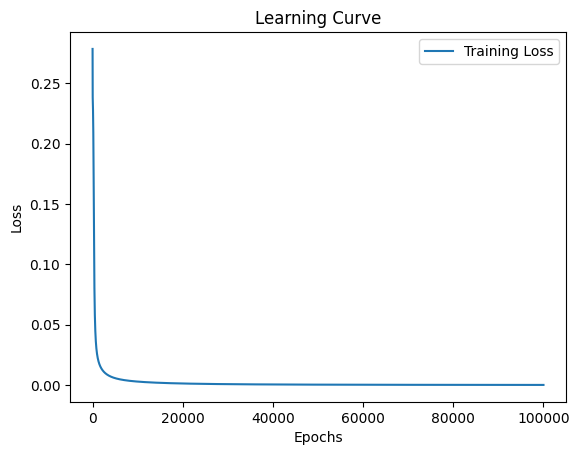

In [780]:
X_train, y_train = generate_linear(n=100)
nn = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1)
loss_history = nn.train(X_train, y_train)


In [781]:
X_test, y_test = generate_linear(n=100)
y_pred, y_pred_binary = nn.predict(X_test)

y_test = y_test.flatten()
y_pred = y_pred.flatten()
y_pred_binary = y_pred_binary.flatten()

for i, (y_true, y_pred_value) in enumerate(zip(y_test, y_pred)):
    print(f"Iter {i:2} |    Ground Truth: {y_true} |    Prediction: {y_pred_value:.6f} |")

accuracy = np.mean(y_pred_binary == y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Iter  0 |    Ground Truth: 1 |    Prediction: 0.999988 |
Iter  1 |    Ground Truth: 0 |    Prediction: 0.000000 |
Iter  2 |    Ground Truth: 0 |    Prediction: 0.000000 |
Iter  3 |    Ground Truth: 1 |    Prediction: 0.999999 |
Iter  4 |    Ground Truth: 0 |    Prediction: 0.000001 |
Iter  5 |    Ground Truth: 1 |    Prediction: 0.999999 |
Iter  6 |    Ground Truth: 1 |    Prediction: 0.999903 |
Iter  7 |    Ground Truth: 0 |    Prediction: 0.000002 |
Iter  8 |    Ground Truth: 1 |    Prediction: 0.999998 |
Iter  9 |    Ground Truth: 0 |    Prediction: 0.000001 |
Iter 10 |    Ground Truth: 1 |    Prediction: 0.572295 |
Iter 11 |    Ground Truth: 0 |    Prediction: 0.000000 |
Iter 12 |    Ground Truth: 0 |    Prediction: 0.000002 |
Iter 13 |    Ground Truth: 1 |    Prediction: 0.999999 |
Iter 14 |    Ground Truth: 0 |    Prediction: 0.000000 |
Iter 15 |    Ground Truth: 0 |    Prediction: 0.000001 |
Iter 16 |    Ground Truth: 1 |    Prediction: 0.999998 |
Iter 17 |    Ground Truth: 1 | 

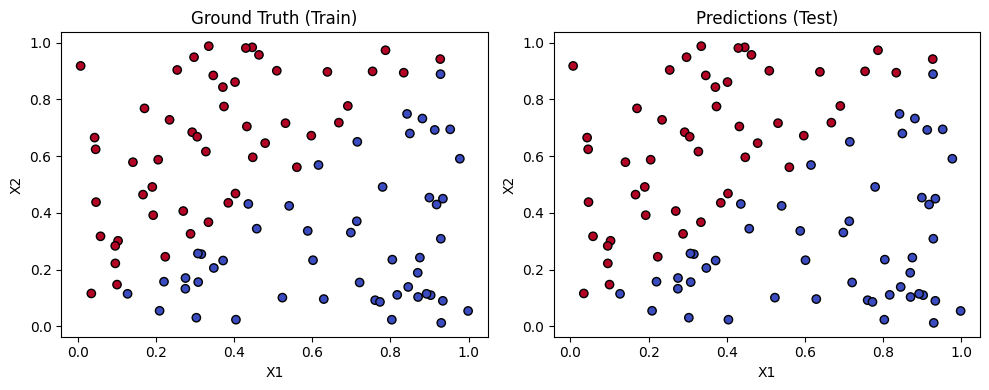

In [782]:
nn.plot_results(X_test, y_test, X_test, y_pred_binary)

Epoch     0	Loss: 0.311851
Epoch  5000	Loss: 0.230229
Epoch 10000	Loss: 0.079776
Epoch 15000	Loss: 0.033106
Epoch 20000	Loss: 0.017708
Epoch 25000	Loss: 0.009087
Epoch 30000	Loss: 0.004910
Epoch 35000	Loss: 0.002957
Epoch 40000	Loss: 0.001966
Epoch 45000	Loss: 0.001410
Epoch 50000	Loss: 0.001069
Epoch 55000	Loss: 0.000845
Epoch 60000	Loss: 0.000690
Epoch 65000	Loss: 0.000577
Epoch 70000	Loss: 0.000493
Epoch 75000	Loss: 0.000427
Epoch 80000	Loss: 0.000376
Epoch 85000	Loss: 0.000334
Epoch 90000	Loss: 0.000300
Epoch 95000	Loss: 0.000271


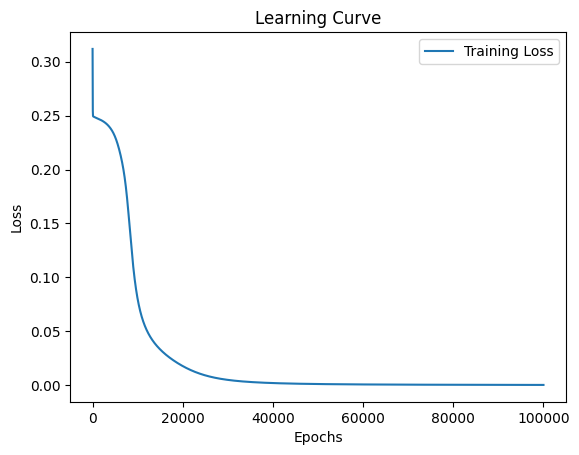

In [783]:
X_train, y_train = generate_XOR_easy()
nn = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01)
loss_history = nn.train(X_train, y_train)


In [784]:
X_test, y_test = generate_XOR_easy()
y_pred, y_pred_binary = nn.predict(X_test)

y_test = y_test.flatten()
y_pred = y_pred.flatten()
y_pred_binary = y_pred_binary.flatten()

for i, (y_true, y_pred_value) in enumerate(zip(y_test, y_pred)):
    print(f"Iter {i:2} |    Ground Truth: {y_true} |    Prediction: {y_pred_value:.6f} |")

accuracy = np.mean(y_pred_binary == y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Iter  0 |    Ground Truth: 0 |    Prediction: 0.004607 |
Iter  1 |    Ground Truth: 1 |    Prediction: 0.999417 |
Iter  2 |    Ground Truth: 0 |    Prediction: 0.000615 |
Iter  3 |    Ground Truth: 1 |    Prediction: 0.999661 |
Iter  4 |    Ground Truth: 0 |    Prediction: 0.000335 |
Iter  5 |    Ground Truth: 1 |    Prediction: 0.999806 |
Iter  6 |    Ground Truth: 0 |    Prediction: 0.001190 |
Iter  7 |    Ground Truth: 1 |    Prediction: 0.999781 |
Iter  8 |    Ground Truth: 0 |    Prediction: 0.016492 |
Iter  9 |    Ground Truth: 1 |    Prediction: 0.965593 |
Iter 10 |    Ground Truth: 0 |    Prediction: 0.045053 |
Iter 11 |    Ground Truth: 0 |    Prediction: 0.015063 |
Iter 12 |    Ground Truth: 1 |    Prediction: 0.961907 |
Iter 13 |    Ground Truth: 0 |    Prediction: 0.002657 |
Iter 14 |    Ground Truth: 1 |    Prediction: 0.999925 |
Iter 15 |    Ground Truth: 0 |    Prediction: 0.000606 |
Iter 16 |    Ground Truth: 1 |    Prediction: 0.999986 |
Iter 17 |    Ground Truth: 0 | 

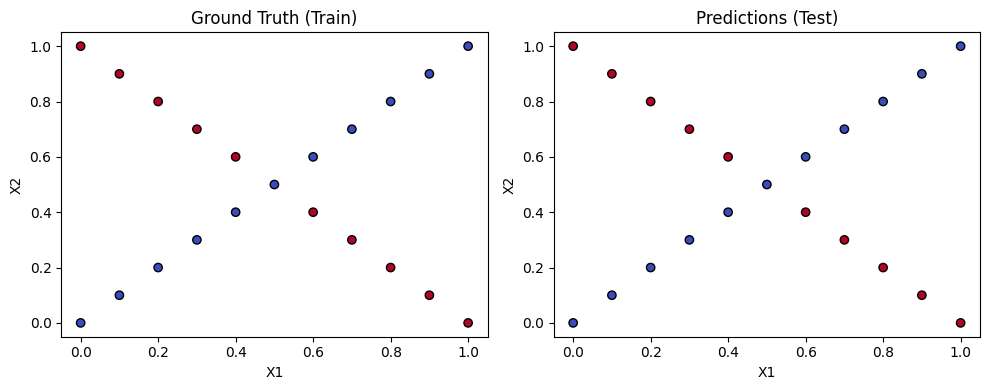

In [785]:
nn.plot_results(X_train, y_train, X_test, y_pred_binary)

In [821]:
def plot_loss_comparison(loss1_history, loss2_history, loss3_history, loss4_history, label1, label2, label3, label4):
    plt.figure(figsize=(8, 6))
    plt.plot(loss1_history, label=label1, linestyle='-', linewidth=2)
    plt.plot(loss2_history, label=label2, linestyle='-', linewidth=2)
    if loss3_history is not None:
        plt.plot(loss3_history, label=label3, linestyle='-', linewidth=2)
    if loss4_history is not None:
        plt.plot(loss4_history, label=label4, linestyle='-', linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()


### different learning rates

Epoch     0	Loss: 0.282823
Epoch  5000	Loss: 0.000542
Epoch 10000	Loss: 0.000109
Epoch 15000	Loss: 0.000055
Epoch 20000	Loss: 0.000036
Epoch 25000	Loss: 0.000026
Epoch 30000	Loss: 0.000020
Epoch 35000	Loss: 0.000016
Epoch 40000	Loss: 0.000014
Epoch 45000	Loss: 0.000012
Epoch 50000	Loss: 0.000010
Epoch 55000	Loss: 0.000009
Epoch 60000	Loss: 0.000008
Epoch 65000	Loss: 0.000007
Epoch 70000	Loss: 0.000007
Epoch 75000	Loss: 0.000006
Epoch 80000	Loss: 0.000006
Epoch 85000	Loss: 0.000005
Epoch 90000	Loss: 0.000005
Epoch 95000	Loss: 0.000005


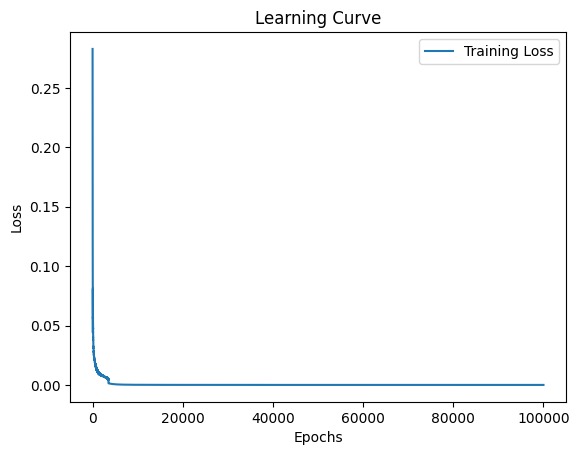

Epoch     0	Loss: 0.436859
Epoch  5000	Loss: 0.008417
Epoch 10000	Loss: 0.004275
Epoch 15000	Loss: 0.002561
Epoch 20000	Loss: 0.001638
Epoch 25000	Loss: 0.001108
Epoch 30000	Loss: 0.000793
Epoch 35000	Loss: 0.000597
Epoch 40000	Loss: 0.000469
Epoch 45000	Loss: 0.000380
Epoch 50000	Loss: 0.000317
Epoch 55000	Loss: 0.000269
Epoch 60000	Loss: 0.000232
Epoch 65000	Loss: 0.000203
Epoch 70000	Loss: 0.000180
Epoch 75000	Loss: 0.000161
Epoch 80000	Loss: 0.000145
Epoch 85000	Loss: 0.000132
Epoch 90000	Loss: 0.000121
Epoch 95000	Loss: 0.000111


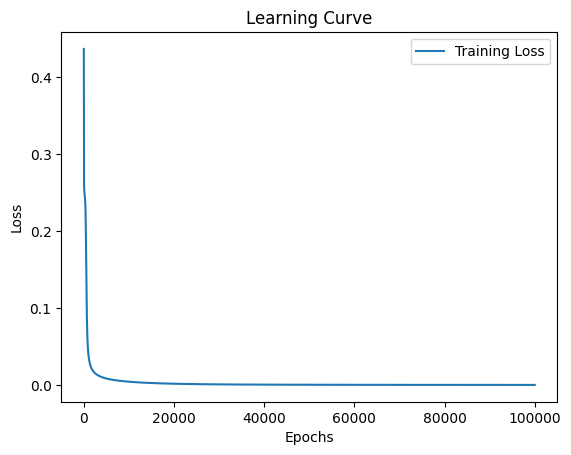

Epoch     0	Loss: 0.257126
Epoch  5000	Loss: 0.059975
Epoch 10000	Loss: 0.028441
Epoch 15000	Loss: 0.020387
Epoch 20000	Loss: 0.016333
Epoch 25000	Loss: 0.013774
Epoch 30000	Loss: 0.011958
Epoch 35000	Loss: 0.010584
Epoch 40000	Loss: 0.009499
Epoch 45000	Loss: 0.008618
Epoch 50000	Loss: 0.007885
Epoch 55000	Loss: 0.007264
Epoch 60000	Loss: 0.006729
Epoch 65000	Loss: 0.006262
Epoch 70000	Loss: 0.005850
Epoch 75000	Loss: 0.005483
Epoch 80000	Loss: 0.005153
Epoch 85000	Loss: 0.004855
Epoch 90000	Loss: 0.004583
Epoch 95000	Loss: 0.004335


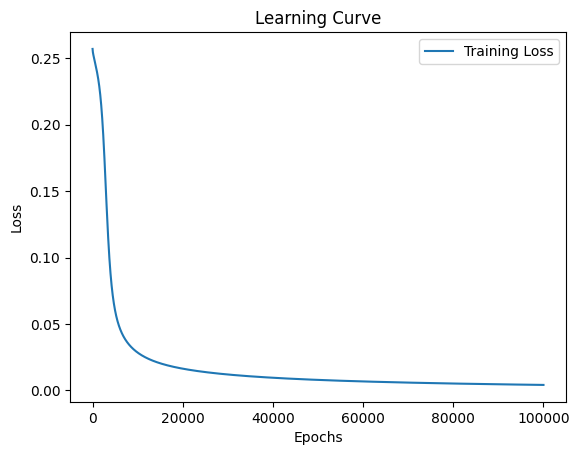

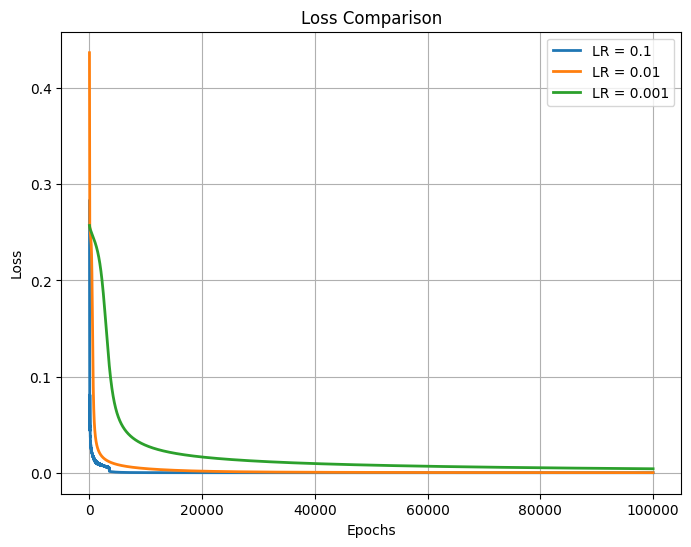

In [ ]:
X_train, y_train = generate_linear(n=100)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.1)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01)
nn3 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.001)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
loss3_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, None, label1="LR = 0.1", label2="LR = 0.01", label3="LR = 0.001", label4=None)


Epoch     0	Loss: 0.290908
Epoch  5000	Loss: 0.000289
Epoch 10000	Loss: 0.000106
Epoch 15000	Loss: 0.000059
Epoch 20000	Loss: 0.000039
Epoch 25000	Loss: 0.000029
Epoch 30000	Loss: 0.000022
Epoch 35000	Loss: 0.000018
Epoch 40000	Loss: 0.000015
Epoch 45000	Loss: 0.000013
Epoch 50000	Loss: 0.000011
Epoch 55000	Loss: 0.000010
Epoch 60000	Loss: 0.000009
Epoch 65000	Loss: 0.000008
Epoch 70000	Loss: 0.000007
Epoch 75000	Loss: 0.000007
Epoch 80000	Loss: 0.000006
Epoch 85000	Loss: 0.000006
Epoch 90000	Loss: 0.000005
Epoch 95000	Loss: 0.000005


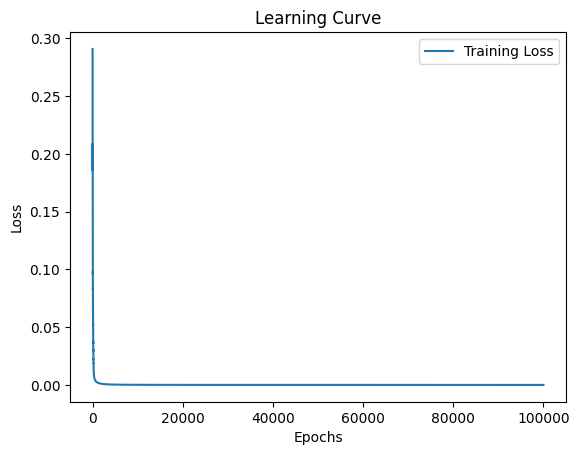

Epoch     0	Loss: 0.248741
Epoch  5000	Loss: 0.004540
Epoch 10000	Loss: 0.002110
Epoch 15000	Loss: 0.001314
Epoch 20000	Loss: 0.000919
Epoch 25000	Loss: 0.000687
Epoch 30000	Loss: 0.000536
Epoch 35000	Loss: 0.000432
Epoch 40000	Loss: 0.000357
Epoch 45000	Loss: 0.000301
Epoch 50000	Loss: 0.000258
Epoch 55000	Loss: 0.000224
Epoch 60000	Loss: 0.000197
Epoch 65000	Loss: 0.000175
Epoch 70000	Loss: 0.000156
Epoch 75000	Loss: 0.000141
Epoch 80000	Loss: 0.000128
Epoch 85000	Loss: 0.000117
Epoch 90000	Loss: 0.000107
Epoch 95000	Loss: 0.000099


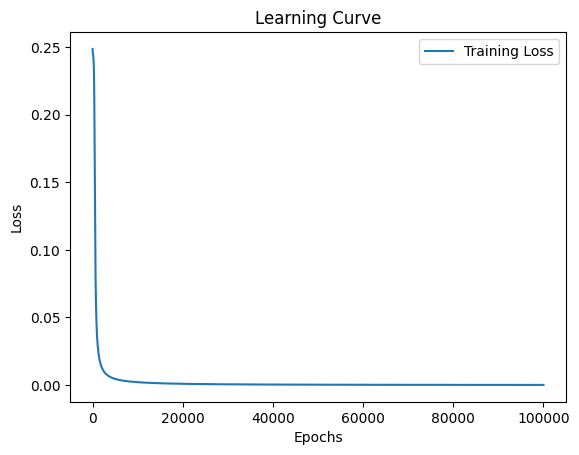

Epoch     0	Loss: 0.261094
Epoch  5000	Loss: 0.074848
Epoch 10000	Loss: 0.026090
Epoch 15000	Loss: 0.015936
Epoch 20000	Loss: 0.011489
Epoch 25000	Loss: 0.008981
Epoch 30000	Loss: 0.007370
Epoch 35000	Loss: 0.006247
Epoch 40000	Loss: 0.005419
Epoch 45000	Loss: 0.004783
Epoch 50000	Loss: 0.004279
Epoch 55000	Loss: 0.003869
Epoch 60000	Loss: 0.003529
Epoch 65000	Loss: 0.003241
Epoch 70000	Loss: 0.002995
Epoch 75000	Loss: 0.002782
Epoch 80000	Loss: 0.002595
Epoch 85000	Loss: 0.002430
Epoch 90000	Loss: 0.002283
Epoch 95000	Loss: 0.002151


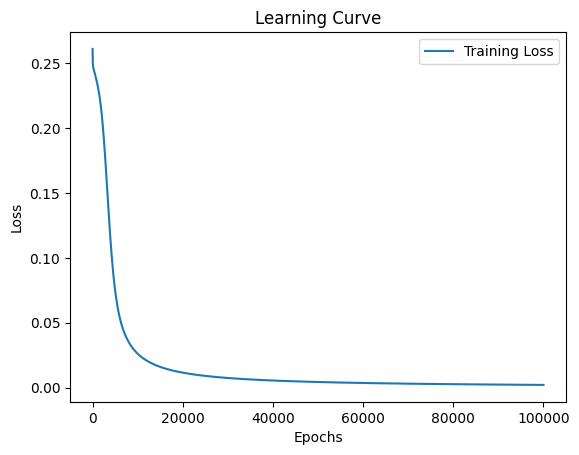

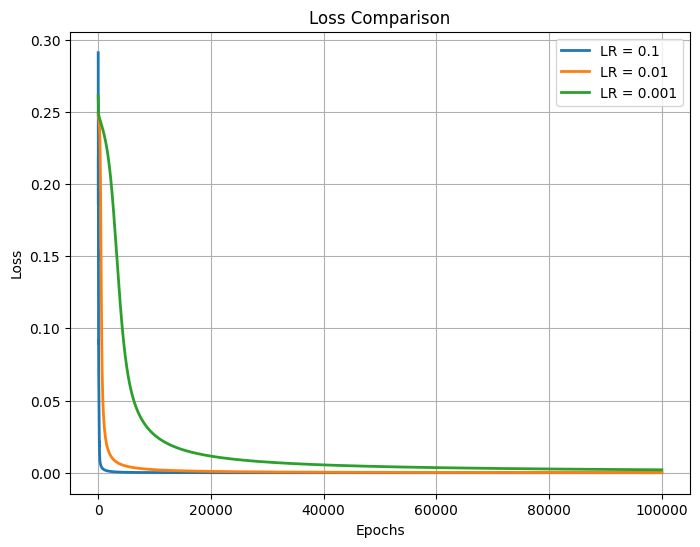

In [ ]:
X_train, y_train = generate_linear(n=100)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.1)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01)
nn3 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.001)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
loss3_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, None, label1="LR = 0.1", label2="LR = 0.01", label3="LR = 0.001", label4=None)


In [ ]:
class NeuralNetwork1:
    def __init__(self, input_dim, hidden_dim1, output_dim, activation="sigmoid", lr=0.01, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.output_dim = output_dim
        self.lr = lr

        self.W1 = np.random.randn(input_dim, hidden_dim1) 
        self.b1 = np.zeros((1, hidden_dim1))

        self.W2 = np.random.randn(hidden_dim1, output_dim) 
        self.b2 = np.zeros((1, output_dim))

        if activation == "sigmoid":
            self.activation = self._sigmoid
            self.activation_deriv = self._sigmoid_deriv
        elif activation == "relu":
            self.activation = self._relu
            self.activation_deriv = self._relu_deriv

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _sigmoid_deriv(self, x):
        return x * (1 - x)
    
    def _relu(self, x):
        return np.maximum(0, x)
    
    def _relu_deriv(self, x):
        return (x > 0).astype(float)
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.activation(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self._sigmoid(self.z2)  

        return self.a2

    def backward(self, X, y, output):
        error_output = output - y 
        d_output = error_output * self._sigmoid_deriv(output)

        error_hidden1 = np.dot(d_output, self.W2.T)
        d_hidden1 = error_hidden1 * self.activation_deriv(self.a1)

        self.W2 -= self.lr * np.dot(self.a1.T, d_output)
        self.b2 -= self.lr * np.sum(d_output, axis=0, keepdims=True)

        self.W1 -= self.lr * np.dot(X.T, d_hidden1)
        self.b1 -= self.lr * np.sum(d_hidden1, axis=0, keepdims=True)

        loss = np.mean(error_output ** 2)
        return loss

    def train(self, X, y, epochs=100000, print_every=5000):
        losses = []
        for epoch in range(epochs):
            output = self.forward(X)
            loss = self.backward(X, y, output)
            losses.append(loss)
            if epoch % print_every == 0:
                print(f"Epoch {epoch:5}\tLoss: {loss:.6f}")

        plt.figure()
        plt.plot(losses, label="Training Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Learning Curve")
        plt.legend()
        plt.show()
        return losses

    def predict(self, X):
        output = self.forward(X)
        return output, (output > 0.5).astype(int)
    
    def plot_results(self, X_train, y_train, X_test, y_test_pred_binary):
        plt.figure(figsize=(10, 4))

        # subplot 1: 顯示訓練資料的真實標籤
        plt.subplot(1, 2, 1)
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten(), 
                    cmap="coolwarm", edgecolors="k")
        plt.title("Ground Truth (Train)")
        plt.xlabel("X1")
        plt.ylabel("X2")

        # subplot 2: 顯示測試資料的預測標籤
        plt.subplot(1, 2, 2)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred_binary.flatten(), 
                    cmap="coolwarm", edgecolors="k")
        plt.title("Predictions (Test)")
        plt.xlabel("X1")
        plt.ylabel("X2")

        plt.tight_layout()
        plt.show()



In [ ]:
class NeuralNetwork4:
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim, activation="sigmoid", lr=0.01, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim1 = hidden_dim3
        self.hidden_dim2 = hidden_dim4
        self.output_dim = output_dim
        self.lr = lr

        self.W1 = np.random.randn(input_dim, hidden_dim1) 
        self.b1 = np.zeros((1, hidden_dim1))

        self.W2 = np.random.randn(hidden_dim1, hidden_dim2) 
        self.b2 = np.zeros((1, hidden_dim2))
        
        self.W3 = np.random.randn(hidden_dim2, hidden_dim3) 
        self.b3 = np.zeros((1, hidden_dim3))

        self.W4 = np.random.randn(hidden_dim3, hidden_dim4) 
        self.b4 = np.zeros((1, hidden_dim4))

        self.W5 = np.random.randn(hidden_dim4, output_dim) 
        self.b5 = np.zeros((1, output_dim))

        if activation == "sigmoid":
            self.activation = self._sigmoid
            self.activation_deriv = self._sigmoid_deriv
        elif activation == "relu":
            self.activation = self._relu
            self.activation_deriv = self._relu_deriv

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _sigmoid_deriv(self, x):
        return x * (1 - x)
    
    def _relu(self, x):
        return np.maximum(0, x)
    
    def _relu_deriv(self, x):
        return (x > 0).astype(float)
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.activation(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.activation(self.z2)
        
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.activation(self.z3)
        
        self.z4 = np.dot(self.a3, self.W4) + self.b4
        self.a4 = self.activation(self.z4)

        self.z5 = np.dot(self.a4, self.W5) + self.b5
        self.a5 = self._sigmoid(self.z5)  

        return self.a5

    def backward(self, X, y, output):
        error_output = output - y 
        d_output = error_output * self._sigmoid_deriv(output)
        
        error_hidden4 = np.dot(d_output, self.W5.T)
        d_hidden4 = error_hidden4 * self.activation_deriv(self.a4)
        
        error_hidden3 = np.dot(d_hidden4, self.W4.T)
        d_hidden3 = error_hidden3 * self.activation_deriv(self.a3)

        error_hidden2 = np.dot(d_hidden3, self.W3.T)
        d_hidden2 = error_hidden2 * self.activation_deriv(self.a2)

        error_hidden1 = np.dot(d_hidden2, self.W2.T)
        d_hidden1 = error_hidden1 * self.activation_deriv(self.a1)

        self.W5 -= self.lr * np.dot(self.a4.T, d_output)
        self.b5 -= self.lr * np.sum(d_output, axis=0, keepdims=True)
        
        self.W4 -= self.lr * np.dot(self.a3.T, d_hidden4)
        self.b4 -= self.lr * np.sum(d_hidden4, axis=0, keepdims=True)
        
        self.W3 -= self.lr * np.dot(self.a2.T, d_hidden3)
        self.b3 -= self.lr * np.sum(d_hidden4, axis=0, keepdims=True)

        self.W2 -= self.lr * np.dot(self.a1.T, d_hidden2)
        self.b2 -= self.lr * np.sum(d_hidden2, axis=0, keepdims=True)

        self.W1 -= self.lr * np.dot(X.T, d_hidden1)
        self.b1 -= self.lr * np.sum(d_hidden1, axis=0, keepdims=True)

        loss = np.mean(error_output ** 2)
        return loss

    def train(self, X, y, epochs=100000, print_every=5000):
        losses = []
        for epoch in range(epochs):
            output = self.forward(X)
            loss = self.backward(X, y, output)
            losses.append(loss)
            if epoch % print_every == 0:
                print(f"Epoch {epoch:5}\tLoss: {loss:.6f}")

        plt.figure()
        plt.plot(losses, label="Training Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Learning Curve")
        plt.legend()
        plt.show()
        return losses

    def predict(self, X):
        output = self.forward(X)
        return output, (output > 0.5).astype(int)
    
    def plot_results(self, X_train, y_train, X_test, y_test_pred_binary):
        plt.figure(figsize=(10, 4))

        # subplot 1: 顯示訓練資料的真實標籤
        plt.subplot(1, 2, 1)
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten(), 
                    cmap="coolwarm", edgecolors="k")
        plt.title("Ground Truth (Train)")
        plt.xlabel("X1")
        plt.ylabel("X2")

        # subplot 2: 顯示測試資料的預測標籤
        plt.subplot(1, 2, 2)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred_binary.flatten(), 
                    cmap="coolwarm", edgecolors="k")
        plt.title("Predictions (Test)")
        plt.xlabel("X1")
        plt.ylabel("X2")

        plt.tight_layout()
        plt.show()



### different numbers of hidden units

Epoch     0	Loss: 0.274598
Epoch  5000	Loss: 0.015219
Epoch 10000	Loss: 0.009534
Epoch 15000	Loss: 0.006905
Epoch 20000	Loss: 0.005284
Epoch 25000	Loss: 0.004193
Epoch 30000	Loss: 0.003428
Epoch 35000	Loss: 0.002875
Epoch 40000	Loss: 0.002462
Epoch 45000	Loss: 0.002146
Epoch 50000	Loss: 0.001897
Epoch 55000	Loss: 0.001697
Epoch 60000	Loss: 0.001532
Epoch 65000	Loss: 0.001395
Epoch 70000	Loss: 0.001278
Epoch 75000	Loss: 0.001178
Epoch 80000	Loss: 0.001091
Epoch 85000	Loss: 0.001015
Epoch 90000	Loss: 0.000948
Epoch 95000	Loss: 0.000888


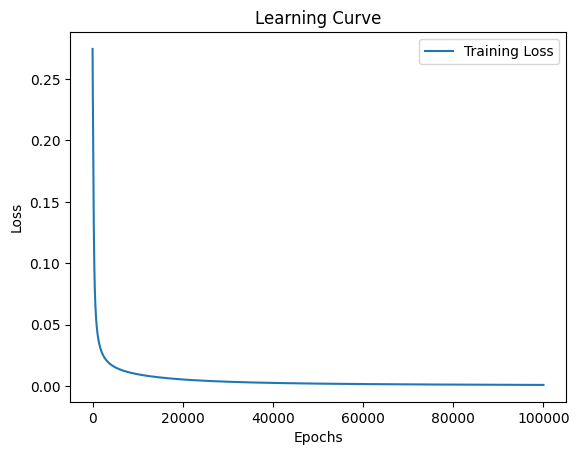

Epoch     0	Loss: 0.257399
Epoch  5000	Loss: 0.006465
Epoch 10000	Loss: 0.002722
Epoch 15000	Loss: 0.001496
Epoch 20000	Loss: 0.000959
Epoch 25000	Loss: 0.000676
Epoch 30000	Loss: 0.000509
Epoch 35000	Loss: 0.000401
Epoch 40000	Loss: 0.000327
Epoch 45000	Loss: 0.000274
Epoch 50000	Loss: 0.000233
Epoch 55000	Loss: 0.000202
Epoch 60000	Loss: 0.000178
Epoch 65000	Loss: 0.000158
Epoch 70000	Loss: 0.000142
Epoch 75000	Loss: 0.000128
Epoch 80000	Loss: 0.000117
Epoch 85000	Loss: 0.000107
Epoch 90000	Loss: 0.000099
Epoch 95000	Loss: 0.000091


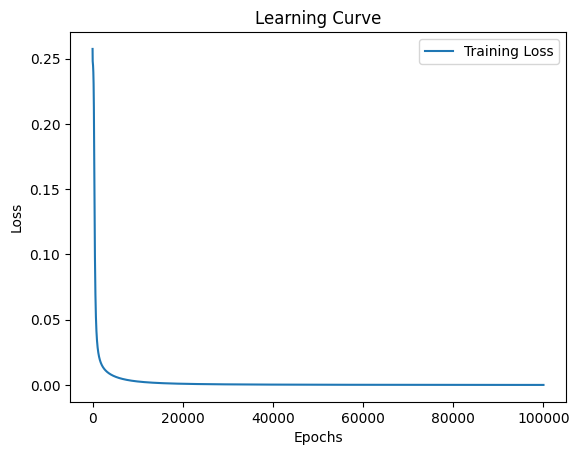

Epoch     0	Loss: 0.249497
Epoch  5000	Loss: 0.001661
Epoch 10000	Loss: 0.000411
Epoch 15000	Loss: 0.000199
Epoch 20000	Loss: 0.000123
Epoch 25000	Loss: 0.000087
Epoch 30000	Loss: 0.000066
Epoch 35000	Loss: 0.000052
Epoch 40000	Loss: 0.000043
Epoch 45000	Loss: 0.000037
Epoch 50000	Loss: 0.000032
Epoch 55000	Loss: 0.000028
Epoch 60000	Loss: 0.000025
Epoch 65000	Loss: 0.000022
Epoch 70000	Loss: 0.000020
Epoch 75000	Loss: 0.000018
Epoch 80000	Loss: 0.000017
Epoch 85000	Loss: 0.000015
Epoch 90000	Loss: 0.000014
Epoch 95000	Loss: 0.000013


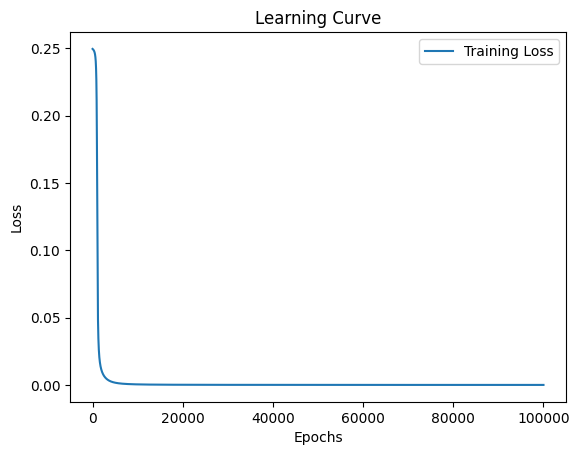

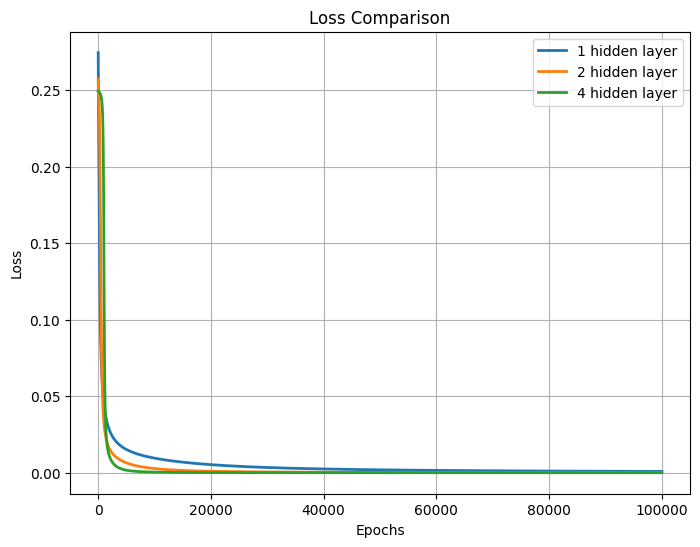

In [ ]:
X_train, y_train = generate_linear(n=100)
nn1 = NeuralNetwork1(input_dim=2, hidden_dim1=4, output_dim=1, lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01)
nn3 = NeuralNetwork4(input_dim=2, hidden_dim1=4, hidden_dim2=4, hidden_dim3=4, hidden_dim4=4, output_dim=1, lr=0.01)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
loss3_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, None, label1="1 hidden layer", label2="2 hidden layer", label3="4 hidden layer", label4=None)

Epoch     0	Loss: 0.283496
Epoch  5000	Loss: 0.224526
Epoch 10000	Loss: 0.103212
Epoch 15000	Loss: 0.054335
Epoch 20000	Loss: 0.036141
Epoch 25000	Loss: 0.024982
Epoch 30000	Loss: 0.017401
Epoch 35000	Loss: 0.012368
Epoch 40000	Loss: 0.009077
Epoch 45000	Loss: 0.006900
Epoch 50000	Loss: 0.005419
Epoch 55000	Loss: 0.004378
Epoch 60000	Loss: 0.003623
Epoch 65000	Loss: 0.003059
Epoch 70000	Loss: 0.002626
Epoch 75000	Loss: 0.002288
Epoch 80000	Loss: 0.002017
Epoch 85000	Loss: 0.001796
Epoch 90000	Loss: 0.001614
Epoch 95000	Loss: 0.001462


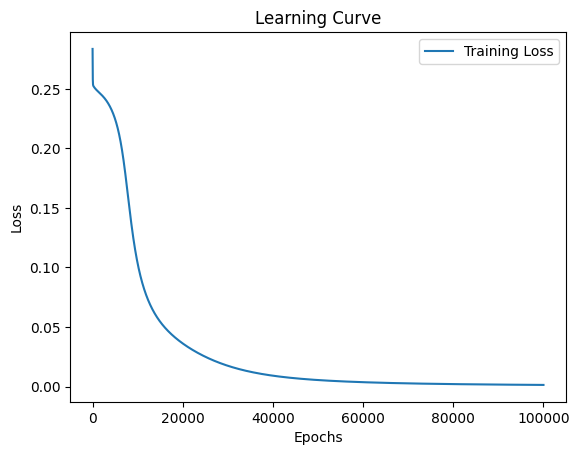

Epoch     0	Loss: 0.310886
Epoch  5000	Loss: 0.249423
Epoch 10000	Loss: 0.249176
Epoch 15000	Loss: 0.248390
Epoch 20000	Loss: 0.241691
Epoch 25000	Loss: 0.121562
Epoch 30000	Loss: 0.037523
Epoch 35000	Loss: 0.017984
Epoch 40000	Loss: 0.008433
Epoch 45000	Loss: 0.004399
Epoch 50000	Loss: 0.002642
Epoch 55000	Loss: 0.001771
Epoch 60000	Loss: 0.001283
Epoch 65000	Loss: 0.000983
Epoch 70000	Loss: 0.000784
Epoch 75000	Loss: 0.000645
Epoch 80000	Loss: 0.000543
Epoch 85000	Loss: 0.000466
Epoch 90000	Loss: 0.000406
Epoch 95000	Loss: 0.000359


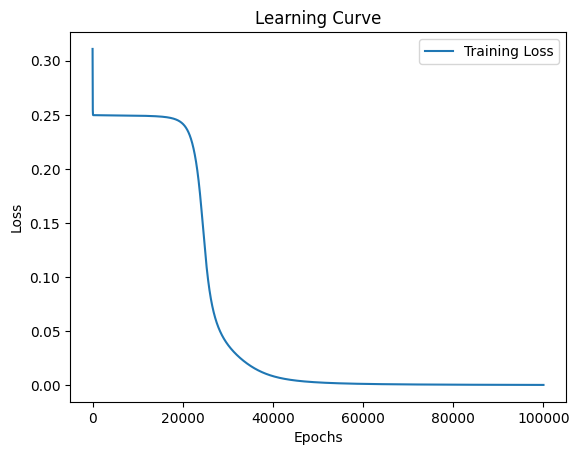

Epoch     0	Loss: 0.261407
Epoch  5000	Loss: 0.249111
Epoch 10000	Loss: 0.248047
Epoch 15000	Loss: 0.235577
Epoch 20000	Loss: 0.186917
Epoch 25000	Loss: 0.162623
Epoch 30000	Loss: 0.006836
Epoch 35000	Loss: 0.002742
Epoch 40000	Loss: 0.001655
Epoch 45000	Loss: 0.001169
Epoch 50000	Loss: 0.000897
Epoch 55000	Loss: 0.000724
Epoch 60000	Loss: 0.000605
Epoch 65000	Loss: 0.000519
Epoch 70000	Loss: 0.000453
Epoch 75000	Loss: 0.000402
Epoch 80000	Loss: 0.000360
Epoch 85000	Loss: 0.000327
Epoch 90000	Loss: 0.000298
Epoch 95000	Loss: 0.000274


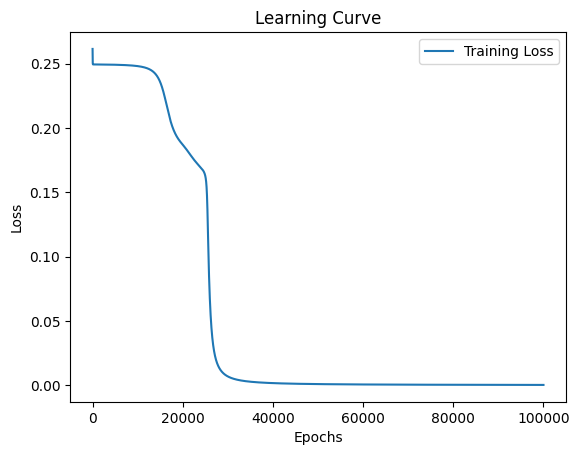

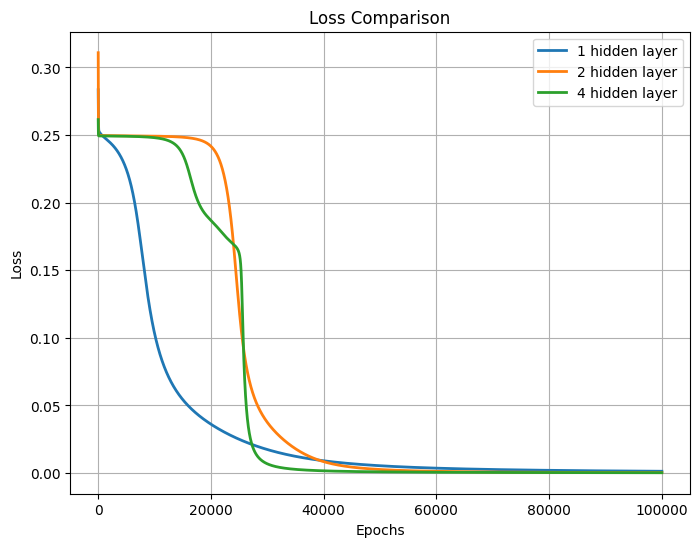

In [ ]:
X_train, y_train = generate_XOR_easy()
nn1 = NeuralNetwork1(input_dim=2, hidden_dim1=4, output_dim=1, lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01)
nn3 = NeuralNetwork4(input_dim=2, hidden_dim1=4, hidden_dim2=4, hidden_dim3=4, hidden_dim4=4, output_dim=1, lr=0.01)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
loss3_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, None, label1="1 hidden layer", label2="2 hidden layer", label3="4 hidden layer", label4=None)

### without activation functions

Epoch     0	Loss: 0.329240
Epoch  5000	Loss: 0.001157
Epoch 10000	Loss: 0.000378
Epoch 15000	Loss: 0.000183
Epoch 20000	Loss: 0.000111
Epoch 25000	Loss: 0.000076
Epoch 30000	Loss: 0.000056
Epoch 35000	Loss: 0.000044
Epoch 40000	Loss: 0.000036
Epoch 45000	Loss: 0.000030
Epoch 50000	Loss: 0.000026
Epoch 55000	Loss: 0.000022
Epoch 60000	Loss: 0.000020
Epoch 65000	Loss: 0.000017
Epoch 70000	Loss: 0.000016
Epoch 75000	Loss: 0.000014
Epoch 80000	Loss: 0.000013
Epoch 85000	Loss: 0.000012
Epoch 90000	Loss: 0.000011
Epoch 95000	Loss: 0.000010


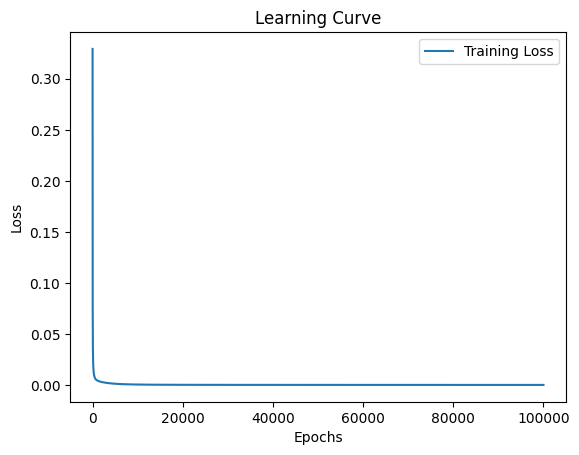

Epoch     0	Loss: 0.252292
Epoch  5000	Loss: 0.005530
Epoch 10000	Loss: 0.003380
Epoch 15000	Loss: 0.002470
Epoch 20000	Loss: 0.001890
Epoch 25000	Loss: 0.001475
Epoch 30000	Loss: 0.001167
Epoch 35000	Loss: 0.000933
Epoch 40000	Loss: 0.000754
Epoch 45000	Loss: 0.000617
Epoch 50000	Loss: 0.000511
Epoch 55000	Loss: 0.000428
Epoch 60000	Loss: 0.000363
Epoch 65000	Loss: 0.000310
Epoch 70000	Loss: 0.000268
Epoch 75000	Loss: 0.000234
Epoch 80000	Loss: 0.000206
Epoch 85000	Loss: 0.000183
Epoch 90000	Loss: 0.000163
Epoch 95000	Loss: 0.000147


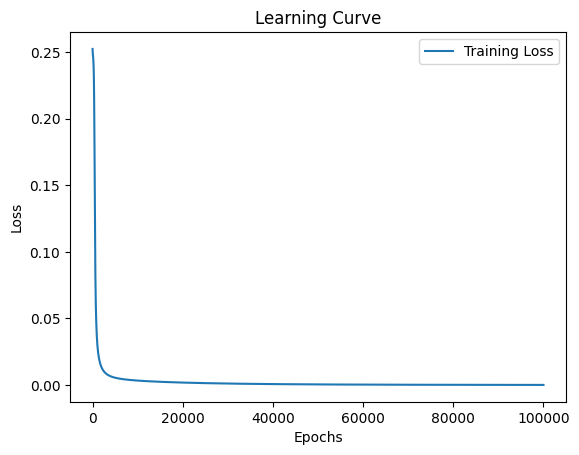

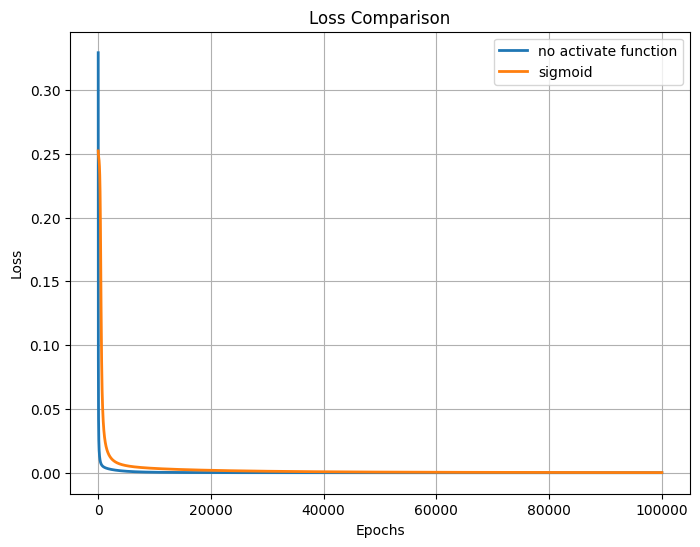

In [ ]:
X_train, y_train = generate_linear(n=100)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation=None, lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, None, None, label1="no activate function", label2="sigmoid", label3=None, label4=None)

In [ ]:
X_train, y_train = generate_linear(n=100)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation=None, lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, lr=0.01)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, None, None, label1="no activate function", label2="sigmoid", label3=None, label4=None)

### different optimizers


Epoch     0	Loss: 0.275075
Epoch  5000	Loss: 0.007032
Epoch 10000	Loss: 0.003934
Epoch 15000	Loss: 0.002543
Epoch 20000	Loss: 0.001747
Epoch 25000	Loss: 0.001255
Epoch 30000	Loss: 0.000939
Epoch 35000	Loss: 0.000727
Epoch 40000	Loss: 0.000579
Epoch 45000	Loss: 0.000473
Epoch 50000	Loss: 0.000395
Epoch 55000	Loss: 0.000335
Epoch 60000	Loss: 0.000289
Epoch 65000	Loss: 0.000252
Epoch 70000	Loss: 0.000223
Epoch 75000	Loss: 0.000198
Epoch 80000	Loss: 0.000178
Epoch 85000	Loss: 0.000161
Epoch 90000	Loss: 0.000147
Epoch 95000	Loss: 0.000135


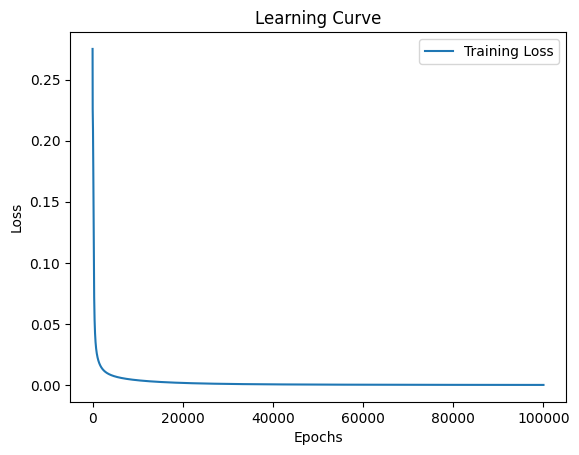

Epoch     0	Loss: 0.258304
Epoch  5000	Loss: 0.000449
Epoch 10000	Loss: 0.000141
Epoch 15000	Loss: 0.000075
Epoch 20000	Loss: 0.000049
Epoch 25000	Loss: 0.000035
Epoch 30000	Loss: 0.000027
Epoch 35000	Loss: 0.000022
Epoch 40000	Loss: 0.000018
Epoch 45000	Loss: 0.000016
Epoch 50000	Loss: 0.000014
Epoch 55000	Loss: 0.000012
Epoch 60000	Loss: 0.000011
Epoch 65000	Loss: 0.000010
Epoch 70000	Loss: 0.000009
Epoch 75000	Loss: 0.000008
Epoch 80000	Loss: 0.000007
Epoch 85000	Loss: 0.000007
Epoch 90000	Loss: 0.000006
Epoch 95000	Loss: 0.000006


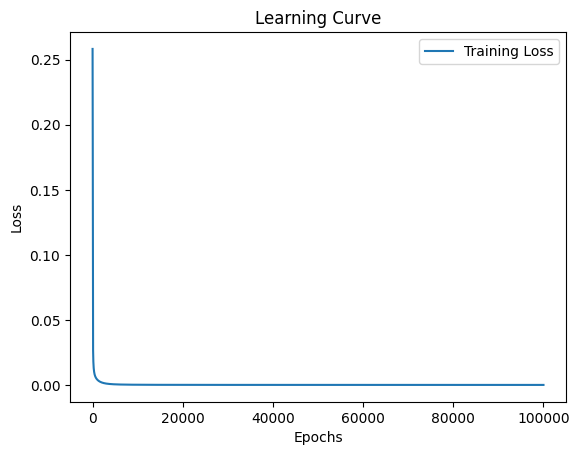

Epoch     0	Loss: 0.250259
Epoch  5000	Loss: 0.063137
Epoch 10000	Loss: 0.038062
Epoch 15000	Loss: 0.028053
Epoch 20000	Loss: 0.022401
Epoch 25000	Loss: 0.018844
Epoch 30000	Loss: 0.016355
Epoch 35000	Loss: 0.014500
Epoch 40000	Loss: 0.013058
Epoch 45000	Loss: 0.011900
Epoch 50000	Loss: 0.010947
Epoch 55000	Loss: 0.010146
Epoch 60000	Loss: 0.009462
Epoch 65000	Loss: 0.008868
Epoch 70000	Loss: 0.008346
Epoch 75000	Loss: 0.007881
Epoch 80000	Loss: 0.007464
Epoch 85000	Loss: 0.007086
Epoch 90000	Loss: 0.006742
Epoch 95000	Loss: 0.006425


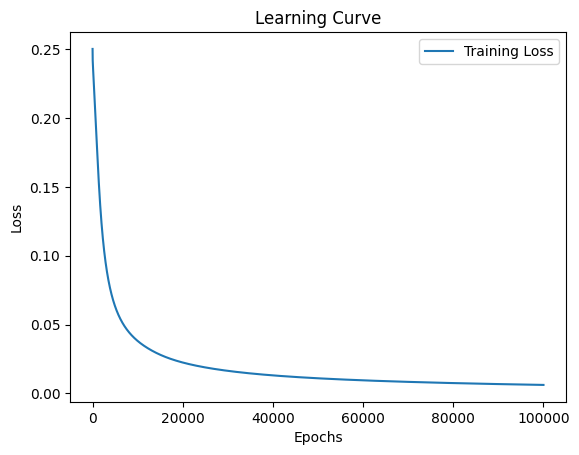

Epoch     0	Loss: 0.277898
Epoch  5000	Loss: 0.000028
Epoch 10000	Loss: 0.000001
Epoch 15000	Loss: 0.000000
Epoch 20000	Loss: 0.000000
Epoch 25000	Loss: 0.000000
Epoch 30000	Loss: 0.000000
Epoch 35000	Loss: 0.000000
Epoch 40000	Loss: 0.000000
Epoch 45000	Loss: 0.000000
Epoch 50000	Loss: 0.000000
Epoch 55000	Loss: 0.000000
Epoch 60000	Loss: 0.000000
Epoch 65000	Loss: 0.000000
Epoch 70000	Loss: 0.000000
Epoch 75000	Loss: 0.000000
Epoch 80000	Loss: 0.000000
Epoch 85000	Loss: 0.000000
Epoch 90000	Loss: 0.000000
Epoch 95000	Loss: 0.000000


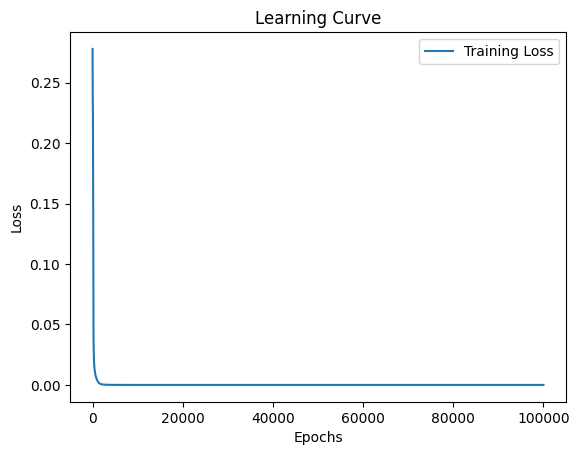

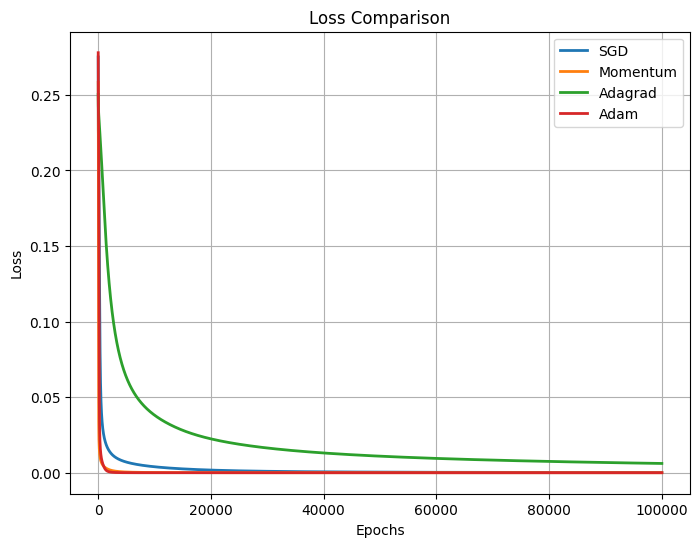

In [828]:
X_train, y_train = generate_linear(n=100)
nn = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="sgd", lr=0.01)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="momentum", lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="adagrad", lr=0.01)
nn3 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="adam", lr=0.01)
loss1_history = nn.train(X_train, y_train)
loss2_history = nn1.train(X_train, y_train)
loss3_history = nn2.train(X_train, y_train)
loss4_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, loss4_history, label1="SGD", label2="Momentum", label3="Adagrad", label4="Adam")


Epoch     0	Loss: 0.254336
Epoch  5000	Loss: 0.248570
Epoch 10000	Loss: 0.233538
Epoch 15000	Loss: 0.073744
Epoch 20000	Loss: 0.017814
Epoch 25000	Loss: 0.005674
Epoch 30000	Loss: 0.002889
Epoch 35000	Loss: 0.001842
Epoch 40000	Loss: 0.001323
Epoch 45000	Loss: 0.001020
Epoch 50000	Loss: 0.000823
Epoch 55000	Loss: 0.000687
Epoch 60000	Loss: 0.000588
Epoch 65000	Loss: 0.000512
Epoch 70000	Loss: 0.000453
Epoch 75000	Loss: 0.000406
Epoch 80000	Loss: 0.000367
Epoch 85000	Loss: 0.000334
Epoch 90000	Loss: 0.000307
Epoch 95000	Loss: 0.000283


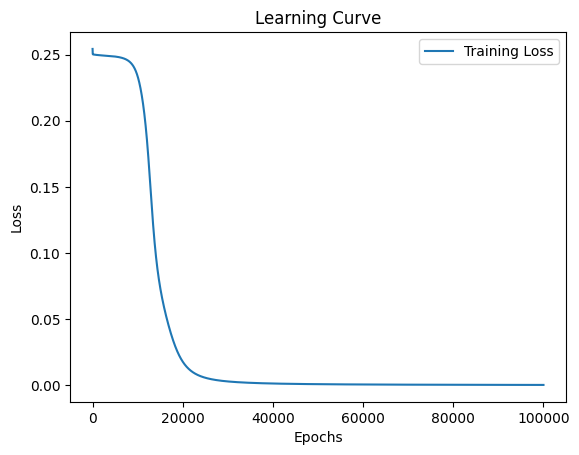

Epoch     0	Loss: 0.321460
Epoch  5000	Loss: 0.000922
Epoch 10000	Loss: 0.000249
Epoch 15000	Loss: 0.000134
Epoch 20000	Loss: 0.000090
Epoch 25000	Loss: 0.000067
Epoch 30000	Loss: 0.000053
Epoch 35000	Loss: 0.000043
Epoch 40000	Loss: 0.000037
Epoch 45000	Loss: 0.000032
Epoch 50000	Loss: 0.000028
Epoch 55000	Loss: 0.000025
Epoch 60000	Loss: 0.000022
Epoch 65000	Loss: 0.000020
Epoch 70000	Loss: 0.000019
Epoch 75000	Loss: 0.000017
Epoch 80000	Loss: 0.000016
Epoch 85000	Loss: 0.000015
Epoch 90000	Loss: 0.000014
Epoch 95000	Loss: 0.000013


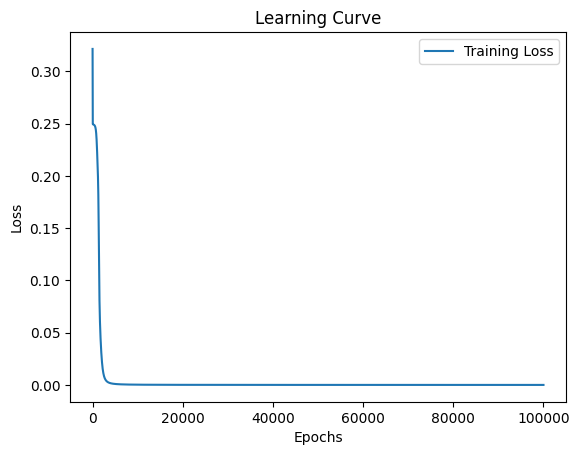

Epoch     0	Loss: 0.276914
Epoch  5000	Loss: 0.220708
Epoch 10000	Loss: 0.109651
Epoch 15000	Loss: 0.070435
Epoch 20000	Loss: 0.054304
Epoch 25000	Loss: 0.045073
Epoch 30000	Loss: 0.038834
Epoch 35000	Loss: 0.034164
Epoch 40000	Loss: 0.030416
Epoch 45000	Loss: 0.027255
Epoch 50000	Loss: 0.024503
Epoch 55000	Loss: 0.022057
Epoch 60000	Loss: 0.019861
Epoch 65000	Loss: 0.017880
Epoch 70000	Loss: 0.016091
Epoch 75000	Loss: 0.014480
Epoch 80000	Loss: 0.013032
Epoch 85000	Loss: 0.011736
Epoch 90000	Loss: 0.010579
Epoch 95000	Loss: 0.009548


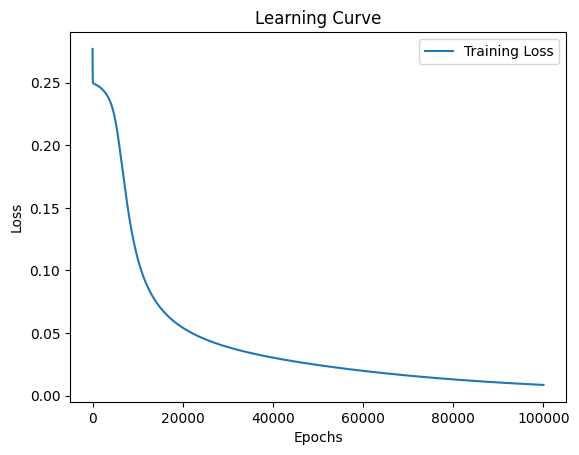

Epoch     0	Loss: 0.291199
Epoch  5000	Loss: 0.000017
Epoch 10000	Loss: 0.000001
Epoch 15000	Loss: 0.000000
Epoch 20000	Loss: 0.000000
Epoch 25000	Loss: 0.000000
Epoch 30000	Loss: 0.000000
Epoch 35000	Loss: 0.000000
Epoch 40000	Loss: 0.000000
Epoch 45000	Loss: 0.000000
Epoch 50000	Loss: 0.000000
Epoch 55000	Loss: 0.000000
Epoch 60000	Loss: 0.000000
Epoch 65000	Loss: 0.000000
Epoch 70000	Loss: 0.000000
Epoch 75000	Loss: 0.000000
Epoch 80000	Loss: 0.000000
Epoch 85000	Loss: 0.000000
Epoch 90000	Loss: 0.000000
Epoch 95000	Loss: 0.000000


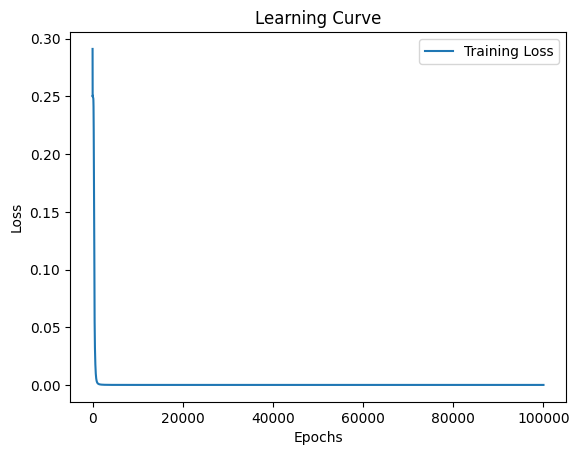

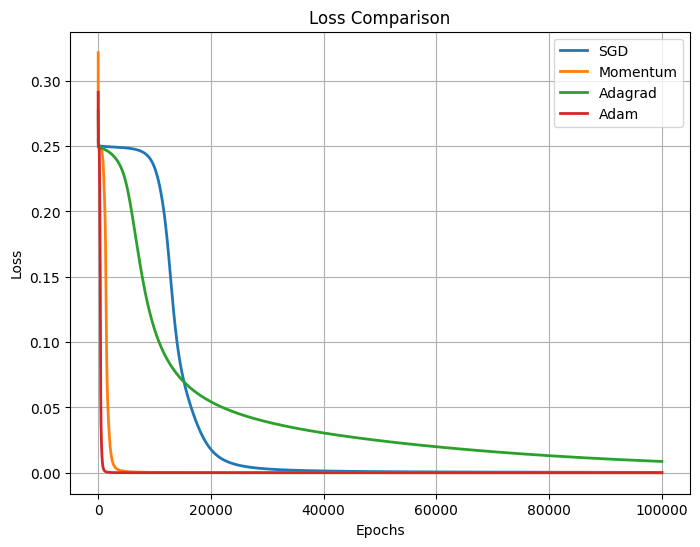

In [834]:
X_train, y_train = generate_XOR_easy()
nn = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="sgd", lr=0.01)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="momentum", lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="adagrad", lr=0.01)
nn3 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, optimizer="adam", lr=0.01)
loss1_history = nn.train(X_train, y_train)
loss2_history = nn1.train(X_train, y_train)
loss3_history = nn2.train(X_train, y_train)
loss4_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, loss4_history, label1="SGD", label2="Momentum", label3="Adagrad", label4="Adam")

### different activation functions

Epoch     0	Loss: 0.282379
Epoch  5000	Loss: 0.004724
Epoch 10000	Loss: 0.001685
Epoch 15000	Loss: 0.000888
Epoch 20000	Loss: 0.000567
Epoch 25000	Loss: 0.000404
Epoch 30000	Loss: 0.000308
Epoch 35000	Loss: 0.000246
Epoch 40000	Loss: 0.000203
Epoch 45000	Loss: 0.000172
Epoch 50000	Loss: 0.000148
Epoch 55000	Loss: 0.000130
Epoch 60000	Loss: 0.000115
Epoch 65000	Loss: 0.000103
Epoch 70000	Loss: 0.000094
Epoch 75000	Loss: 0.000085
Epoch 80000	Loss: 0.000078
Epoch 85000	Loss: 0.000072
Epoch 90000	Loss: 0.000067
Epoch 95000	Loss: 0.000062


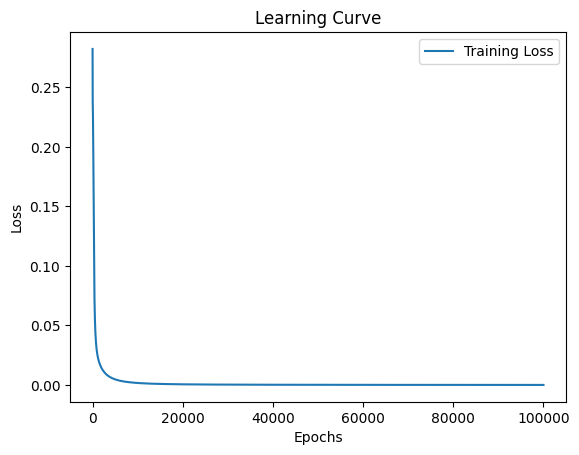

Epoch     0	Loss: 0.309968
Epoch  5000	Loss: 0.000317
Epoch 10000	Loss: 0.000114
Epoch 15000	Loss: 0.000064
Epoch 20000	Loss: 0.000043
Epoch 25000	Loss: 0.000032
Epoch 30000	Loss: 0.000025
Epoch 35000	Loss: 0.000020
Epoch 40000	Loss: 0.000017
Epoch 45000	Loss: 0.000014
Epoch 50000	Loss: 0.000013
Epoch 55000	Loss: 0.000011
Epoch 60000	Loss: 0.000010
Epoch 65000	Loss: 0.000009
Epoch 70000	Loss: 0.000008
Epoch 75000	Loss: 0.000007
Epoch 80000	Loss: 0.000007
Epoch 85000	Loss: 0.000006
Epoch 90000	Loss: 0.000006
Epoch 95000	Loss: 0.000006


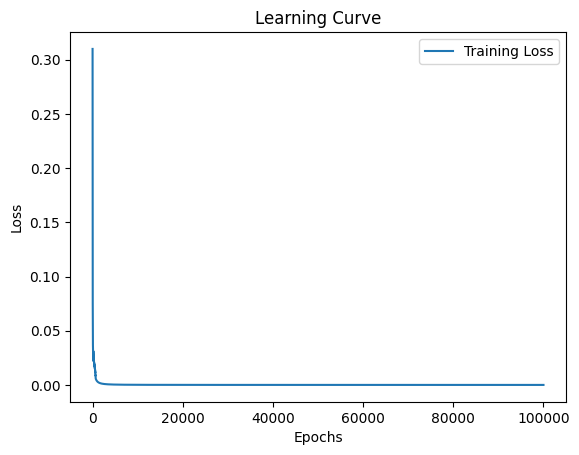

Epoch     0	Loss: 0.166905
Epoch  5000	Loss: 0.000263
Epoch 10000	Loss: 0.000103
Epoch 15000	Loss: 0.000061
Epoch 20000	Loss: 0.000042
Epoch 25000	Loss: 0.000032
Epoch 30000	Loss: 0.000025
Epoch 35000	Loss: 0.000021
Epoch 40000	Loss: 0.000018
Epoch 45000	Loss: 0.000015
Epoch 50000	Loss: 0.000014
Epoch 55000	Loss: 0.000012
Epoch 60000	Loss: 0.000011
Epoch 65000	Loss: 0.000010
Epoch 70000	Loss: 0.000009
Epoch 75000	Loss: 0.000008
Epoch 80000	Loss: 0.000008
Epoch 85000	Loss: 0.000007
Epoch 90000	Loss: 0.000007
Epoch 95000	Loss: 0.000006


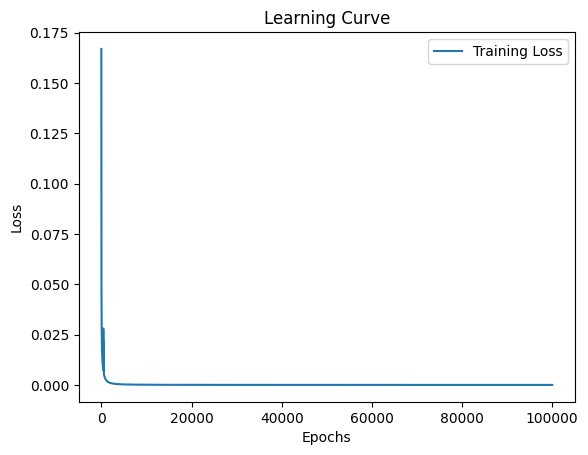

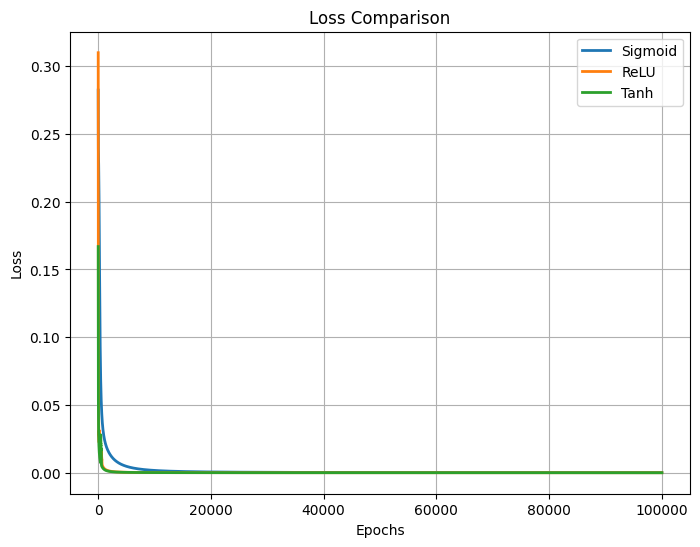

In [835]:
X_train, y_train = generate_linear(n=100)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="sigmoid", lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="relu", lr=0.01)
nn3 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="tanh", lr=0.01)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
loss3_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, None, label1="Sigmoid", label2="ReLU", label3="Tanh", label4=None)

Epoch     0	Loss: 0.255990
Epoch  5000	Loss: 0.006840
Epoch 10000	Loss: 0.002890
Epoch 15000	Loss: 0.001589
Epoch 20000	Loss: 0.001007
Epoch 25000	Loss: 0.000695
Epoch 30000	Loss: 0.000511
Epoch 35000	Loss: 0.000393
Epoch 40000	Loss: 0.000313
Epoch 45000	Loss: 0.000257
Epoch 50000	Loss: 0.000215
Epoch 55000	Loss: 0.000184
Epoch 60000	Loss: 0.000159
Epoch 65000	Loss: 0.000140
Epoch 70000	Loss: 0.000124
Epoch 75000	Loss: 0.000111
Epoch 80000	Loss: 0.000101
Epoch 85000	Loss: 0.000091
Epoch 90000	Loss: 0.000084
Epoch 95000	Loss: 0.000077


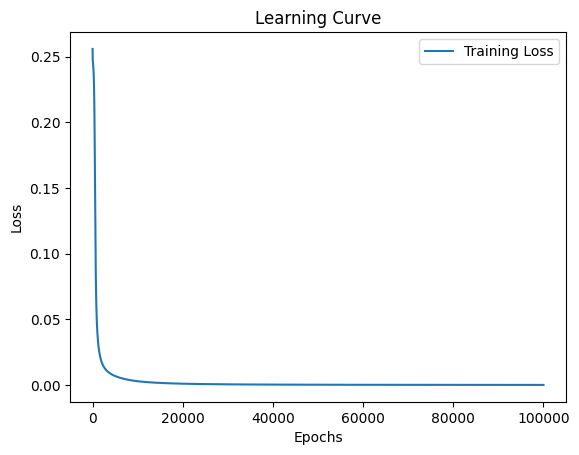

Epoch     0	Loss: 0.228770
Epoch  5000	Loss: 0.000352
Epoch 10000	Loss: 0.000137
Epoch 15000	Loss: 0.000082
Epoch 20000	Loss: 0.000058
Epoch 25000	Loss: 0.000044
Epoch 30000	Loss: 0.000036
Epoch 35000	Loss: 0.000030
Epoch 40000	Loss: 0.000026
Epoch 45000	Loss: 0.000022
Epoch 50000	Loss: 0.000020
Epoch 55000	Loss: 0.000018
Epoch 60000	Loss: 0.000016
Epoch 65000	Loss: 0.000015
Epoch 70000	Loss: 0.000014
Epoch 75000	Loss: 0.000013
Epoch 80000	Loss: 0.000012
Epoch 85000	Loss: 0.000011
Epoch 90000	Loss: 0.000010
Epoch 95000	Loss: 0.000010


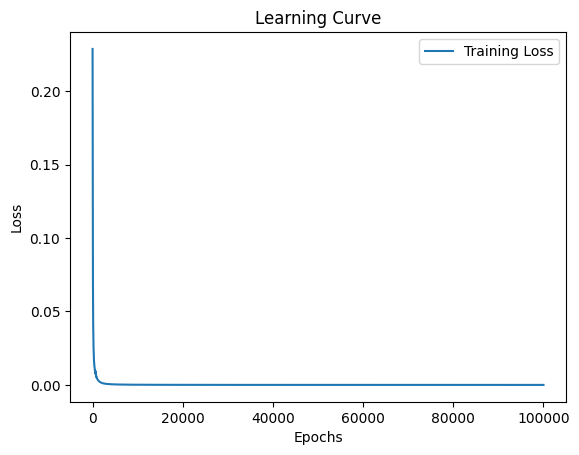

Epoch     0	Loss: 0.503717
Epoch  5000	Loss: 0.000345
Epoch 10000	Loss: 0.000131
Epoch 15000	Loss: 0.000075
Epoch 20000	Loss: 0.000051
Epoch 25000	Loss: 0.000038
Epoch 30000	Loss: 0.000030
Epoch 35000	Loss: 0.000024
Epoch 40000	Loss: 0.000021
Epoch 45000	Loss: 0.000018
Epoch 50000	Loss: 0.000016
Epoch 55000	Loss: 0.000014
Epoch 60000	Loss: 0.000012
Epoch 65000	Loss: 0.000011
Epoch 70000	Loss: 0.000010
Epoch 75000	Loss: 0.000009
Epoch 80000	Loss: 0.000009
Epoch 85000	Loss: 0.000008
Epoch 90000	Loss: 0.000008
Epoch 95000	Loss: 0.000007


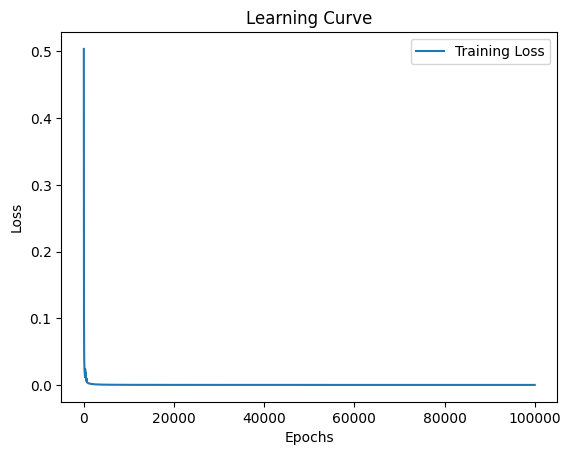

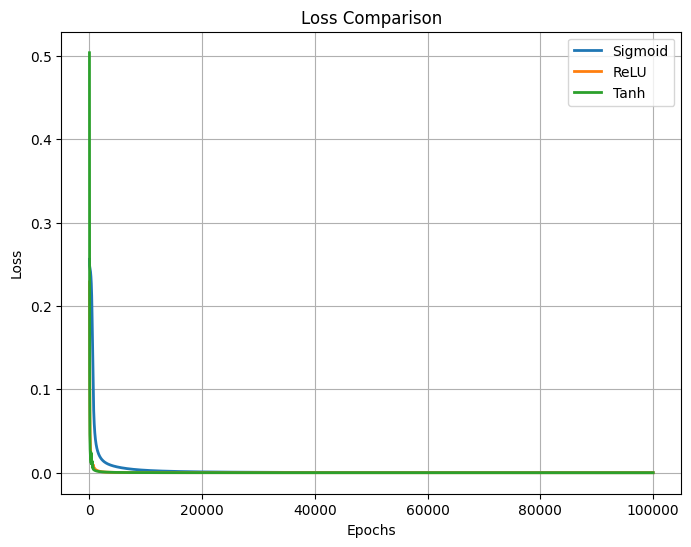

In [836]:
X_train, y_train = generate_linear(n=100)
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="sigmoid", lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="relu", lr=0.01)
nn3 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="tanh", lr=0.01)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
loss3_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, None, label1="Sigmoid", label2="ReLU", label3="Tanh", label4=None)

Epoch     0	Loss: 0.262153
Epoch  5000	Loss: 0.240535
Epoch 10000	Loss: 0.177457
Epoch 15000	Loss: 0.044121
Epoch 20000	Loss: 0.011382
Epoch 25000	Loss: 0.004841
Epoch 30000	Loss: 0.002819
Epoch 35000	Loss: 0.001924
Epoch 40000	Loss: 0.001438
Epoch 45000	Loss: 0.001138
Epoch 50000	Loss: 0.000936
Epoch 55000	Loss: 0.000793
Epoch 60000	Loss: 0.000685
Epoch 65000	Loss: 0.000603
Epoch 70000	Loss: 0.000537
Epoch 75000	Loss: 0.000483
Epoch 80000	Loss: 0.000439
Epoch 85000	Loss: 0.000402
Epoch 90000	Loss: 0.000371
Epoch 95000	Loss: 0.000344


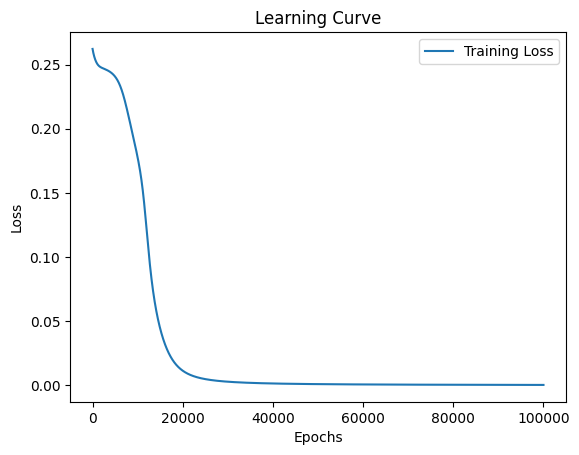

Epoch     0	Loss: 0.353940
Epoch  5000	Loss: 0.000791
Epoch 10000	Loss: 0.000268
Epoch 15000	Loss: 0.000150
Epoch 20000	Loss: 0.000101
Epoch 25000	Loss: 0.000075
Epoch 30000	Loss: 0.000059
Epoch 35000	Loss: 0.000048
Epoch 40000	Loss: 0.000041
Epoch 45000	Loss: 0.000035
Epoch 50000	Loss: 0.000031
Epoch 55000	Loss: 0.000027
Epoch 60000	Loss: 0.000024
Epoch 65000	Loss: 0.000022
Epoch 70000	Loss: 0.000020
Epoch 75000	Loss: 0.000018
Epoch 80000	Loss: 0.000017
Epoch 85000	Loss: 0.000016
Epoch 90000	Loss: 0.000015
Epoch 95000	Loss: 0.000014


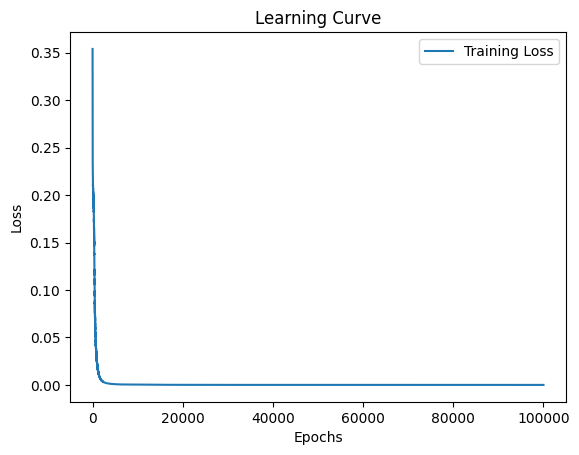

Epoch     0	Loss: 0.357842
Epoch  5000	Loss: 0.002737
Epoch 10000	Loss: 0.000940
Epoch 15000	Loss: 0.000543
Epoch 20000	Loss: 0.000376
Epoch 25000	Loss: 0.000285
Epoch 30000	Loss: 0.000228
Epoch 35000	Loss: 0.000190
Epoch 40000	Loss: 0.000162
Epoch 45000	Loss: 0.000141
Epoch 50000	Loss: 0.000125
Epoch 55000	Loss: 0.000112
Epoch 60000	Loss: 0.000101
Epoch 65000	Loss: 0.000092
Epoch 70000	Loss: 0.000085
Epoch 75000	Loss: 0.000079
Epoch 80000	Loss: 0.000073
Epoch 85000	Loss: 0.000068
Epoch 90000	Loss: 0.000064
Epoch 95000	Loss: 0.000060


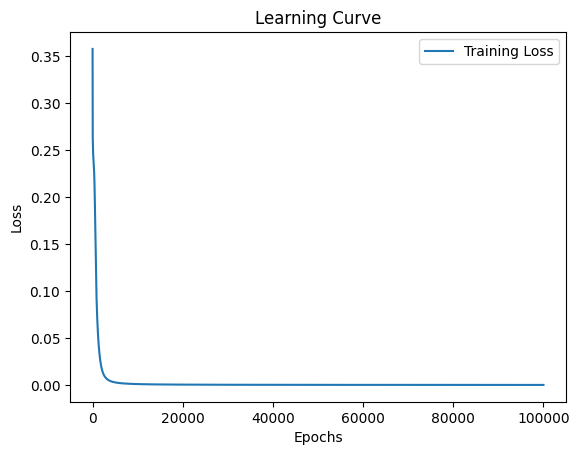

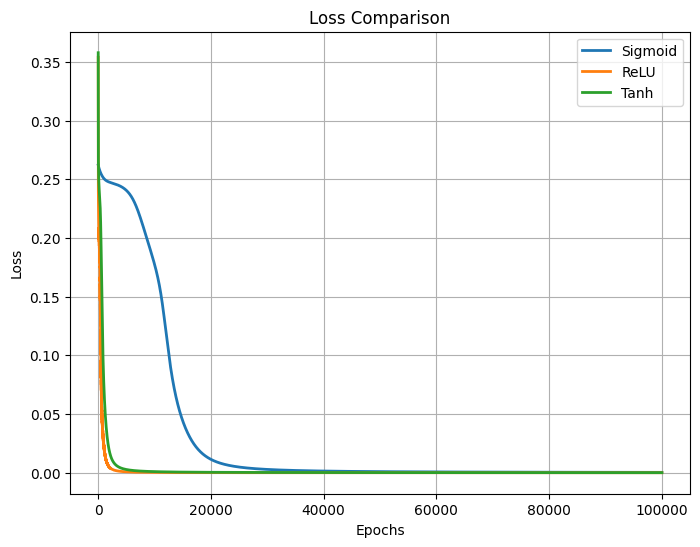

In [837]:
X_train, y_train = generate_XOR_easy()
nn1 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="sigmoid", lr=0.01)
nn2 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="relu", lr=0.01)
nn3 = NeuralNetwork(input_dim=2, hidden_dim1=4, hidden_dim2=4, output_dim=1, activation="tanh", lr=0.01)
loss1_history = nn1.train(X_train, y_train)
loss2_history = nn2.train(X_train, y_train)
loss3_history = nn3.train(X_train, y_train)
plot_loss_comparison(loss1_history, loss2_history, loss3_history, None, label1="Sigmoid", label2="ReLU", label3="Tanh", label4=None)

### convolutional layers

In [ ]:
class NeuralNetwork:
    def __init__(self, use_conv=False, 
                 input_dim=2,  
                 conv_params=None,  
                 hidden_dim=4, 
                 output_dim=1, 
                 activation="sigmoid", lr=0.01, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.use_conv = use_conv
        self.lr = lr
        if self.use_conv:
            self.input_channels = conv_params.get("input_channels", 1)
            self.num_filters = conv_params.get("num_filters", 8)
            self.filter_size = conv_params.get("filter_size", 3)
            self.stride = conv_params.get("stride", 1)
            self.padding = conv_params.get("padding", 0)
            # 輸入圖片的尺寸
            self.input_height = conv_params.get("height", 28)
            self.input_width = conv_params.get("width", 28)
            # 初始化卷積層參數
            self.filters = np.random.randn(self.num_filters, self.input_channels, self.filter_size, self.filter_size) * 0.1
            self.biases_conv = np.zeros((self.num_filters, 1))
            # 計算卷積層輸出尺寸
            self.conv_out_height = int((self.input_height + 2*self.padding - self.filter_size) / self.stride) + 1
            self.conv_out_width  = int((self.input_width + 2*self.padding - self.filter_size) / self.stride) + 1
            # 全連接層的輸入維度
            fc_input_dim = self.num_filters * self.conv_out_height * self.conv_out_width
        else:
            fc_input_dim = input_dim  # 若不用卷積層，則直接使用 input_dim
        
        # 初始化全連接層參數
        self.W1 = np.random.randn(fc_input_dim, hidden_dim) * 0.1
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.1
        self.b2 = np.zeros((1, output_dim))
        
        # 設定激活函數
        if activation == "sigmoid":
            self.activation = self._sigmoid
            self.activation_deriv = self._sigmoid_deriv
        elif activation == "relu":
            self.activation = self._relu
            self.activation_deriv = self._relu_deriv
        elif activation == "tanh":
            self.activation = np.tanh
            self.activation_deriv = lambda x: 1 - np.tanh(x) ** 2
        elif activation is None:
            self.activation = self.no_activation
            self.activation_deriv = self.no_activation_deriv

    def no_activation(self, x):
        return x

    def no_activation_deriv(self, x):
        return 1

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _sigmoid_deriv(self, x):
        return x * (1 - x)
    
    def _relu(self, x):
        return np.maximum(0, x)
    
    def _relu_deriv(self, x):
        return (x > 0).astype(float)
    
    def conv_forward(self, X):
        """
        卷積層前向傳播
        :param X: 輸入資料 shape = (batch_size, channels, height, width)
        :return: 卷積層輸出，shape = (batch_size, num_filters, conv_out_height, conv_out_width)
        """
        self.X = X  # 保存輸入，用於反向傳播
        batch_size, channels, height, width = X.shape
        X_padded = np.pad(X, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
        self.X_padded = X_padded
        out = np.zeros((batch_size, self.num_filters, self.conv_out_height, self.conv_out_width))
        for b in range(batch_size):
            for f in range(self.num_filters):
                for i in range(self.conv_out_height):
                    for j in range(self.conv_out_width):
                        h_start = i * self.stride
                        h_end = h_start + self.filter_size
                        w_start = j * self.stride
                        w_end = w_start + self.filter_size
                        region = X_padded[b, :, h_start:h_end, w_start:w_end]
                        out[b, f, i, j] = np.sum(region * self.filters[f]) + self.biases_conv[f]
        self.conv_out = out  # 保存卷積層輸出
        return out

    def flatten(self, X):
        return X.reshape(X.shape[0], -1)
    
    def fc_forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.activation(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        # 輸出層固定用 sigmoid (適用於二分類)
        self.a2 = self._sigmoid(self.z2)
        return self.a2

    def forward(self, X):
        # 如果啟用卷積層，先進行卷積前向傳播，再 flatten 輸出後送入全連接層
        if self.use_conv:
            conv_out = self.conv_forward(X)
            flat = self.flatten(conv_out)
            output = self.fc_forward(flat)
        else:
            output = self.fc_forward(X)
        return output

    def backward(self, X, y, output):
        """
        反向傳播僅針對全連接層，這裡不實作卷積層的梯度傳播 (可擴充)
        """
        error = output - y 
        d_output = error * self._sigmoid_deriv(output)
        grad_W2 = np.dot(self.a1.T, d_output)
        grad_b2 = np.sum(d_output, axis=0, keepdims=True)
        d_hidden = np.dot(d_output, self.W2.T) * self.activation_deriv(self.a1)
        grad_W1 = np.dot(self.z1.shape[0] and self.flatten(self.conv_out).T, d_hidden) if self.use_conv else np.dot(X.T, d_hidden)
        grad_b1 = np.sum(d_hidden, axis=0, keepdims=True)
        
        # 只更新全連接層參數
        self.W2 -= self.lr * grad_W2
        self.b2 -= self.lr * grad_b2
        if self.use_conv:
            self.W1 -= self.lr * grad_W1  # 此處計算較簡單，實際應用中需正確反向傳播
        else:
            self.W1 -= self.lr * grad_W1
        self.b1 -= self.lr * grad_b1

        loss = np.mean(error ** 2)
        return loss

    def train(self, X, y, epochs=1000, print_every=100):
        losses = []
        for epoch in range(epochs):
            output = self.forward(X)
            loss = self.backward(X, y, output)
            losses.append(loss)
            if epoch % print_every == 0:
                print(f"Epoch {epoch:5}\tLoss: {loss:.6f}")
        plt.figure()
        plt.plot(losses, label="Training Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Learning Curve")
        plt.legend()
        plt.show()
        return losses

    def predict(self, X):
        output = self.forward(X)
        return output, (output > 0.5).astype(int)
    
    def plot_results(self, X_train, y_train, X_test, y_test_pred):
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten(), cmap="coolwarm", edgecolors="k")
        plt.title("Ground Truth (Train)")
        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.subplot(1, 2, 2)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred.flatten(), cmap="coolwarm", edgecolors="k")
        plt.title("Predictions (Test)")
        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.tight_layout()
        plt.show()
